# 06: Phenotype Autoencoder & Two-Phase Pre-training

This notebook documents ProToPhen's two-phase pre-training strategy, which
learns the structure of Cell Painting phenotype space before training the
protein→phenotype mapping.

**Contents**
1. [Setup](#1-setup)
2. [Configuration](#2-configuration)
3. [Phase 1: Learning Phenotype Space](#3-phase-1-learning-phenotype-space)
4. [Phase 2: Protein→Phenotype Mapping](#4-phase-2-proteinphenotype-mapping)
5. [Integration with serving pipeline](#5-integration-with-serving-pipeline)
6. [Summary & CLI reference](#6-summary--cli-reference)

## Overview

```
┌──────────────────────────────────────────────────────────────────────┐
│  Phase 1: Phenotype Space Pre-training (ALL JUMP-CP plates)          │
│                                                                      │
│  Cell Painting features ──► Encoder ──► Latent ──► Decoder ──► Recon │
│       (1500-D)              (MLP)     (256-D)    (MLP)     (1500-D)  │
│                                         │                            │
│                               Contrastive loss                       │
│                           (same gene → similar)                      │
└──────────────────────────────────────────────────────────────────────┘

┌──────────────────────────────────────────────────────────────────────┐
│  Phase 2: Protein→Phenotype Mapping (ORF + CRISPR plates)            │
│                                                                      │
│  ESM-2 embedding ──► Protein Encoder ──► Latent ──► Frozen Decoder   │
│     (1280-D)            (MLP)           (256-D)    (from Phase 1)    │
│                                                        │             │
│                                             Reconstructed features   │
│                                                    (1500-D)          │
│                                                        │             │
│                                         MSE loss vs actual features  │
└──────────────────────────────────────────────────────────────────────┘
```

**Why two phases?**

1. **Phase 1** uses *all* JUMP-CP plates (~2,525 plates, ~130K treatments)
   including compounds, which vastly outnumber KO/OE-type perturbations.  The
   autoencoder learns the manifold of biologically meaningful Cell Painting
   responses: which feature combinations co-occur, which are noise, and
   what the natural clusters look like.

2. **Phase 2** freezes the decoder and trains only a protein encoder to
   predict into the learned latent space.  Because the decoder is pre-trained,
   the protein encoder is forced to produce latent vectors that correspond to
   real biological phenotypes, even with limited protein training data.

## 1. Setup

In [1]:
import warnings
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
from torch.amp import GradScaler, autocast
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import DataLoader

# ProToPhen imports
from protophen.models.autoencoder import (
    AutoencoderLoss,
    PhenotypeAutoencoder,
    PhenotypeAutoencoderConfig,
    PretrainingConfig,
    PretrainingDataset,
    compute_latent_silhouette,
    compute_replicate_correlation,
    load_autoencoder_from_checkpoint,
    save_phase1_checkpoint,
)
from protophen.models.protophen import ProToPhenConfig, ProToPhenModel
from protophen.data.dataset import ProtoPhenDataset
from protophen.training.trainer import Trainer, TrainerConfig
from protophen.training.callbacks import (
    CheckpointCallback,
    EarlyStoppingCallback,
    LoggingCallback,
    ProgressCallback,
)

warnings.filterwarnings("ignore", category=FutureWarning)
sns.set_theme(style="whitegrid", font_scale=1.1)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Output directory for notebook artefacts
NOTEBOOK_DIR = Path("data/notebook_06")
NOTEBOOK_DIR.mkdir(parents=True, exist_ok=True)
print(f"Artefacts: {NOTEBOOK_DIR}")

Device: cuda
Artefacts: data\notebook_06


## 2. Configuration

The full two-phase pre-training is configured via `configs/pretraining.yaml`.
Here we load it and inspect the key settings.

In [2]:
# Load config (use default if YAML not present)
config_path = Path("configs/pretraining.yaml")
if config_path.exists():
    config = PretrainingConfig.from_yaml(config_path)
    print(f"Loaded config from {config_path}")
else:
    config = PretrainingConfig()
    print("Using default PretrainingConfig")

# Display key settings
print("\n── Autoencoder Architecture ──")
print(f"  input_dim:              {config.autoencoder.input_dim}")
print(f"  latent_dim:             {config.autoencoder.latent_dim}")
print(f"  encoder_hidden_dims:    {config.autoencoder.encoder_hidden_dims}")
print(f"  decoder_hidden_dims:    {config.autoencoder.effective_decoder_hidden_dims}")
print(f"  variational:            {config.autoencoder.variational}")
print(f"  skip_connections:       {config.autoencoder.use_skip_connections}")

print("\n── Phase 1 Training ──")
print(f"  epochs:                 {config.phase1.training.epochs}")
print(f"  batch_size:             {config.phase1.training.batch_size}")
print(f"  learning_rate:          {config.phase1.training.learning_rate}")
print(f"  reconstruction_weight:  {config.phase1.loss.reconstruction_weight}")
print(f"  contrastive_weight:     {config.phase1.loss.contrastive_weight}")

print("\n── Phase 2 Training ──")
print(f"  epochs:                 {config.phase2.training.epochs}")
print(f"  protein_encoder_dims:   {config.phase2.protein_encoder.hidden_dims}")
print(f"  decoder_frozen:         {config.phase2.freeze.decoder}")

Using default PretrainingConfig

── Autoencoder Architecture ──
  input_dim:              1500
  latent_dim:             256
  encoder_hidden_dims:    [1024, 512]
  decoder_hidden_dims:    [512, 1024]
  variational:            False
  skip_connections:       True

── Phase 1 Training ──
  epochs:                 100
  batch_size:             256
  learning_rate:          0.001
  reconstruction_weight:  1.0
  contrastive_weight:     0.1

── Phase 2 Training ──
  epochs:                 50
  protein_encoder_dims:   [1024, 512]
  decoder_frozen:         True


## 3. Phase 1: Learning Phenotype Space

Phase 1 trains a phenotype autoencoder on Cell Painting profiles from *all*
JUMP-CP plate types.  The autoencoder learns:

- **Reconstruction**: which feature combinations are biologically coherent
- **Contrastive structure**: replicates of the same treatment should map to
  nearby points in latent space

In production, this runs on ~130K treatments via `scripts/pretrain_phenotype.py`.
Here we demonstrate with synthetic data that mirrors JUMP-CP statistics.

> I *might* document a full pre-training run once I've scoped feasibility of a run on my device to check it won't break things 

### 3.1 Create Synthetic Pre-training Data

We simulate a dataset with realistic properties:
- 5,0000 samples across 5000 treatments (10 replicates each)
- 1500 Cell Painting features
- Feature correlations and treatment-specific shifts

**UPDATE 21/02/2026** The original simulated data is almost perfectly isotropic and Gaussian. This probably isn't a fair comparison to the JUMP-CP data, because the autoencoder is supposed to learn the manifold of phentoypic responses detected by Cell Painting (which features co-occur, what 'noise' looks like, and what natural clusters look like); with isotropic Gaussian data there is no manifold to learn. The reason the baseline model was dominating is because the frozen decoder used for pretraining (which essentially learned nothing in Phase 1) is constraining Phase 2 learning through a nonsense filter, while the baseline model optimises freely via direct mapping.

While the optimal solution is to pretrain on the actual JUMP-CP data (as its structure is real), I want to run a quick experiment using structured synthetic data (low intrinsic dimensionality, block correl structure, heavy-tailed effect sizes, and within-treatment consistency with noise) to see if the pretrained model improves when the data is not so obviously 'perfect'.

In [3]:
# --- Structured synthetic data generation ---
# Mimics key statistical properties of real Cell Painting profiles:
#   • Low intrinsic dimensionality (100-D manifold in 2000-D space)
#   • Block correlation structure (feature groups load on shared factors)
#   • Heavy-tailed treatment effect sizes (most subtle, some dramatic)
#   • MoA-like cluster structure (treatments group by mechanism)
#   • Heterogeneous per-feature variance
#   • Non-Gaussian marginals for a subset of features

N_SAMPLES = 50000
N_FEATURES = 1500
N_TREATMENTS = 5000
REPLICATES_PER_TREATMENT = N_SAMPLES // N_TREATMENTS

print(f"Generating structured synthetic data: {N_SAMPLES} samples, "
      f"{N_FEATURES} features, {N_TREATMENTS} treatments")

rng = np.random.default_rng(SEED)

# ── 1. Block-structured factor loading matrix ───────────────────────
# Mimics Cell Painting compartment/channel grouping: features within a
# measurement module (e.g., "Cells_AreaShape_*") share underlying latent
# factors, while features across modules are weakly coupled.
n_latent = 100                                # effective dimensionality
n_blocks = 20                                 # "measurement modules"
feats_per_block = N_FEATURES // n_blocks      # 100 features per block
factors_per_block = 15                        # each block driven by ~15 factors

W = np.zeros((N_FEATURES, n_latent), dtype=np.float32)
for b in range(n_blocks):
    fi = b * feats_per_block
    fo = fi + feats_per_block
    # Sliding window: adjacent blocks share some factors (biological overlap)
    fc = int(b * (n_latent - factors_per_block) / max(n_blocks - 1, 1))
    fj = np.arange(fc, fc + factors_per_block) % n_latent
    W[fi:fo][:, fj] = rng.standard_normal(
        (feats_per_block, factors_per_block)
    ).astype(np.float32) * 0.5

# Weak global coupling across all blocks (mild cross-compartment correlations)
W += rng.standard_normal(W.shape).astype(np.float32) * 0.05

# ── 2. Heterogeneous per-feature scales ─────────────────────────────
# Real Cell Painting features vary widely in dynamic range/informativeness.
# Heavy-tailed scale distribution: most features moderate, some very large.
feature_scales = (
    np.abs(rng.standard_t(df=4, size=N_FEATURES)).astype(np.float32) * 0.5 + 0.3
)
W *= feature_scales[:, None]

# ── 3. Treatment effects with MoA clusters + heavy tails ────────────
# Treatments cluster by mechanism of action (as in real biology).
# Effect magnitudes are heavy-tailed: most perturbations are subtle
# (weak phenotype), a few are dramatic (strong, distinct phenotype).
n_moa = 50
moa_ids = rng.integers(0, n_moa, size=N_TREATMENTS)
moa_centres = rng.standard_normal(
    (n_moa, n_latent)
).astype(np.float32) * 1.5

# Heavy-tailed per-treatment effect magnitude (Student-t, df=3)
effect_magnitudes = np.abs(
    rng.standard_t(df=3, size=N_TREATMENTS)
).astype(np.float32)

# Each treatment = MoA centre + small treatment-specific offset, scaled
treatment_centres = (
    moa_centres[moa_ids]
    + rng.standard_normal((N_TREATMENTS, n_latent)).astype(np.float32) * 0.3
) * effect_magnitudes[:, None]

# ── 4. Generate replicate samples (vectorised) ──────────────────────
# Each replicate = treatment latent centre + biological replicate noise
sample_treatment_idx = np.repeat(np.arange(N_TREATMENTS), REPLICATES_PER_TREATMENT)

z_all = (
    treatment_centres[sample_treatment_idx]
    + rng.standard_normal((N_SAMPLES, n_latent)).astype(np.float32) * 0.3
)

# Project latent codes to feature space through block-structured loadings
features = z_all @ W.T  # (N_SAMPLES, N_FEATURES)

# Heteroscedastic observation noise (noisier features have more noise)
features += (
    rng.standard_normal(features.shape).astype(np.float32)
    * 0.2 * feature_scales[None, :]
)

# ── 5. Non-Gaussian marginals for ~30% of features ─────────────────
# Real Cell Painting features often have heavy tails / skew.
# Apply a mild power transform to a random subset.
heavy_tail_mask = rng.random(N_FEATURES) < 0.3
for j in np.where(heavy_tail_mask)[0]:
    features[:, j] = np.sign(features[:, j]) * np.abs(features[:, j]) ** 1.3

# ── 6. Construct label and plate arrays ─────────────────────────────
labels = np.array([f"treatment_{t:04d}" for t in sample_treatment_idx])
plates = np.array([f"plate_{t % 10}" for t in sample_treatment_idx])

p1_feature_mean = features.mean(axis=0)
p1_feature_std  = features.std(axis=0)

# ── 7. Standardise features (mimics post-curation normalisation) ────
features = (features - features.mean(axis=0)) / (features.std(axis=0) + 1e-8)
features = features.astype(np.float32)

# ── Summary statistics ──────────────────────────────────────────────
print(f"Features shape:       {features.shape}")
print(f"Feature range:        [{features.min():.2f}, {features.max():.2f}]")
print(f"Unique treatments:    {len(set(labels))}")
print(f"Unique plates:        {len(set(plates))}")
print(f"Latent dimensionality: {n_latent}")
print(f"Correlation blocks:    {n_blocks} blocks × {feats_per_block} features")
print(f"MoA clusters:          {n_moa}")
print(f"Heavy-tailed features: {heavy_tail_mask.sum()} / {N_FEATURES} "
      f"({100*heavy_tail_mask.mean():.0f}%)")
print(f"Effect magnitude stats: median={np.median(effect_magnitudes):.2f}, "
      f"max={effect_magnitudes.max():.2f}, "
      f"frac>2.0={(effect_magnitudes > 2.0).mean():.1%}")

Generating structured synthetic data: 50000 samples, 1500 features, 5000 treatments
Features shape:       (50000, 1500)
Feature range:        [-50.69, 56.11]
Unique treatments:    5000
Unique plates:        10
Latent dimensionality: 100
Correlation blocks:    20 blocks × 75 features
MoA clusters:          50
Heavy-tailed features: 444 / 1500 (30%)
Effect magnitude stats: median=0.75, max=22.37, frac>2.0=13.7%


In [4]:
# Create PretrainingDataset
full_dataset = PretrainingDataset(
    phenotype_features=features,
    treatment_labels=labels,
    plate_ids=plates,
    augmentation_noise_std=0.02,
)

train_dataset, val_dataset = full_dataset.split(
    train_frac=0.9, val_frac=0.1, seed=SEED,
)

print(f"Train: {len(train_dataset):,} samples")
print(f"Val:   {len(val_dataset):,} samples")
print(f"Features per sample: {full_dataset.n_features}")
print(f"Unique treatments:   {full_dataset.n_treatments}")

2026-02-21 20:45:29 | INFO     | protophen.models.autoencoder:__init__:1355 | PretrainingDataset: 50,000 samples, 1500 features, 5,000 unique treatments
2026-02-21 20:45:29 | INFO     | protophen.models.autoencoder:__init__:1355 | PretrainingDataset: 45,000 samples, 1500 features, 5,000 unique treatments
2026-02-21 20:45:29 | INFO     | protophen.models.autoencoder:__init__:1355 | PretrainingDataset: 5,000 samples, 1500 features, 3,272 unique treatments
2026-02-21 20:45:29 | INFO     | protophen.models.autoencoder:split:1517 | PretrainingDataset split: train=45000, val=5000


Train: 45,000 samples
Val:   5,000 samples
Features per sample: 1500
Unique treatments:   5000


### 3.2 Inspect the Data

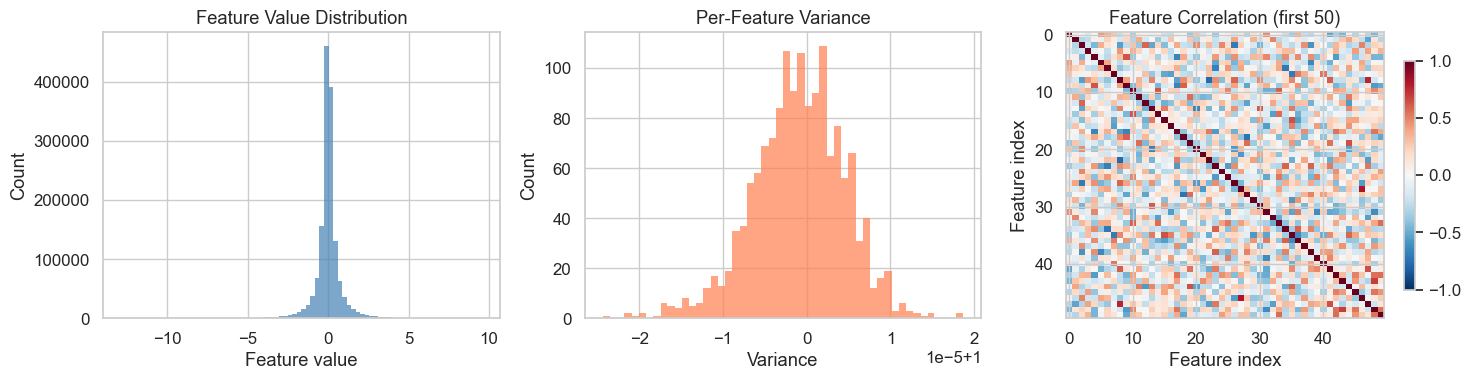

Data looks well-behaved: standardised, correlated, varied.


In [5]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Feature distribution
sample_features = features[:1000].flatten()
axes[0].hist(sample_features, bins=80, color="steelblue", alpha=0.7, edgecolor="none")
axes[0].set_xlabel("Feature value")
axes[0].set_ylabel("Count")
axes[0].set_title("Feature Value Distribution")

# Per-feature variance
feature_var = features.var(axis=0)
axes[1].hist(feature_var, bins=50, color="coral", alpha=0.7, edgecolor="none")
axes[1].set_xlabel("Variance")
axes[1].set_ylabel("Count")
axes[1].set_title("Per-Feature Variance")

# Feature correlation (subset)
corr_matrix = np.corrcoef(features[:, :50].T)
im = axes[2].imshow(corr_matrix, cmap="RdBu_r", vmin=-1, vmax=1, aspect="auto")
axes[2].set_title("Feature Correlation (first 50)")
axes[2].set_xlabel("Feature index")
axes[2].set_ylabel("Feature index")
plt.colorbar(im, ax=axes[2], shrink=0.8)

plt.tight_layout()
plt.savefig(NOTEBOOK_DIR / "phase1_data_overview.png", dpi=150, bbox_inches="tight")
plt.show()
print("Data looks well-behaved: standardised, correlated, varied.")

### 3.3 Build the Autoencoder

In [6]:
# Override input_dim to match synthetic data
ae_config = PhenotypeAutoencoderConfig(
    input_dim=N_FEATURES,
    latent_dim=64,                    # smaller for demo
    encoder_hidden_dims=[128, 96],    # smaller for demo
    decoder_hidden_dims=None,         # symmetric
    activation="gelu",
    dropout=0.1,
    use_layer_norm=True,
    use_residual=True,
    use_skip_connections=False,         # NB changed in testing due to low performance with synthetic data
    variational=False,
    weight_init="kaiming",
)

autoencoder = PhenotypeAutoencoder(ae_config).to(device)
print(autoencoder)
print(f"\nParameter count: {autoencoder.n_parameters:,}")

# Quick forward pass sanity check
dummy = torch.randn(4, N_FEATURES, device=device)
out = autoencoder(dummy)
print(f"\nForward pass check:")
print(f"  Input:          {dummy.shape}")
print(f"  Reconstruction: {out['reconstruction'].shape}")
print(f"  Latent:         {out['latent'].shape}")

2026-02-21 20:45:30 | INFO     | protophen.models.autoencoder:__init__:462 | PhenotypeAutoencoder initialised: input_dim=1500, latent_dim=64, variational=False, skip_connections=False, params=423,900


PhenotypeAutoencoder(input_dim=1500, latent_dim=64, variational=False, params=423,900)

Parameter count: 423,900

Forward pass check:
  Input:          torch.Size([4, 1500])
  Reconstruction: torch.Size([4, 1500])
  Latent:         torch.Size([4, 64])


### 3.4 Phase 1 Training Demo

We run a small-scale training loop that mirrors `scripts/pretrain_phenotype.py`.
In production this would run for ~100 epochs on the full JUMP-CP dataset;
here we use 20 epochs on our synthetic data.

In [7]:
# --- Training configuration ---
NUM_EPOCHS = 20
BATCH_SIZE = 128
LR = 1e-3
EVAL_EVERY = 2

# DataLoaders
def collate_fn(batch):
    """Stack tensors, gather strings into lists."""
    result = {}
    for key in batch[0]:
        values = [b[key] for b in batch]
        if isinstance(values[0], torch.Tensor):
            result[key] = torch.stack(values)
        else:
            result[key] = values
    return result

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True,
    drop_last=True, collate_fn=collate_fn,
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE * 2, shuffle=False,
    collate_fn=collate_fn,
)

# Loss function
loss_fn = AutoencoderLoss(
    config=config.phase1.loss,
    variational=ae_config.variational,
)

# Optimiser and scheduler
optimiser = torch.optim.AdamW(
    autoencoder.parameters(), lr=LR, weight_decay=0.01,
)
total_steps = len(train_loader) * NUM_EPOCHS
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimiser, T_max=total_steps, eta_min=1e-6,
)

print(f"Training: {NUM_EPOCHS} epochs, {len(train_loader)} batches/epoch")
print(f"Loss: reconstruction (w={config.phase1.loss.reconstruction_weight}) + "
      f"contrastive (w={config.phase1.loss.contrastive_weight})")

Training: 20 epochs, 351 batches/epoch
Loss: reconstruction (w=1.0) + contrastive (w=0.1)


In [8]:
# --- Phase 1 training loop ---
history = {
    "epoch": [],
    "train_total": [],
    "train_recon": [],
    "train_contrastive": [],
    "val_total": [],
    "val_recon": [],
    "val_contrastive": [],
    "replicate_corr": [],
    "silhouette": [],
}

for epoch in range(1, NUM_EPOCHS + 1):
    # ---- Train ----
    autoencoder.train()
    epoch_losses = defaultdict(float)
    n_batches = 0

    for batch in train_loader:
        features_batch = batch["phenotype_features"].to(device)
        labels_batch = batch["treatment_label"].to(device)

        outputs = autoencoder(features_batch)
        losses = loss_fn(outputs, features_batch, labels_batch)

        optimiser.zero_grad()
        losses["total"].backward()
        clip_grad_norm_(autoencoder.parameters(), 1.0)
        optimiser.step()
        scheduler.step()

        for k, v in losses.items():
            epoch_losses[k] += v.item()
        n_batches += 1

    avg_train = {k: v / n_batches for k, v in epoch_losses.items()}

    history["epoch"].append(epoch)
    history["train_total"].append(avg_train["total"])
    history["train_recon"].append(avg_train["reconstruction"])
    history["train_contrastive"].append(avg_train["contrastive"])

    # ---- Validate ----
    if epoch % EVAL_EVERY == 0 or epoch == NUM_EPOCHS:
        autoencoder.eval()
        val_losses = defaultdict(float)
        all_latents, all_labels = [], []
        n_val = 0

        with torch.no_grad():
            for batch in val_loader:
                features_batch = batch["phenotype_features"].to(device)
                labels_batch = batch["treatment_label"].to(device)

                outputs = autoencoder(features_batch)
                losses = loss_fn(outputs, features_batch, labels_batch)

                for k, v in losses.items():
                    val_losses[k] += v.item()
                n_val += 1

                enc_out = autoencoder.encode(features_batch)
                all_latents.append(enc_out["latent"].cpu())
                all_labels.append(batch["treatment_label"])

        avg_val = {k: v / n_val for k, v in val_losses.items()}
        latents = torch.cat(all_latents)
        latent_labels = torch.cat(all_labels)

        rep_corr = compute_replicate_correlation(latents, latent_labels)
        sil = compute_latent_silhouette(latents, latent_labels)

        history["val_total"].append(avg_val["total"])
        history["val_recon"].append(avg_val["reconstruction"])
        history["val_contrastive"].append(avg_val["contrastive"])
        history["replicate_corr"].append(rep_corr)
        history["silhouette"].append(sil)

        print(
            f"Epoch {epoch:>3d}/{NUM_EPOCHS} | "
            f"train={avg_train['total']:.4f} | "
            f"val={avg_val['total']:.4f} | "
            f"rep_corr={rep_corr:.4f} | "
            f"sil={sil:.4f} | "
            f"lr={optimiser.param_groups[0]['lr']:.2e}"
        )
    else:
        history["val_total"].append(np.nan)
        history["val_recon"].append(np.nan)
        history["val_contrastive"].append(np.nan)
        history["replicate_corr"].append(np.nan)
        history["silhouette"].append(np.nan)

print("\nPhase 1 training complete!")

Epoch   2/20 | train=0.5668 | val=0.4139 | rep_corr=0.9642 | sil=-0.0425 | lr=9.76e-04
Epoch   4/20 | train=0.3681 | val=0.3083 | rep_corr=0.9556 | sil=-0.0327 | lr=9.05e-04
Epoch   6/20 | train=0.2921 | val=0.2473 | rep_corr=0.9590 | sil=-0.0231 | lr=7.94e-04
Epoch   8/20 | train=0.2558 | val=0.2210 | rep_corr=0.9597 | sil=-0.0162 | lr=6.55e-04
Epoch  10/20 | train=0.2375 | val=0.2118 | rep_corr=0.9612 | sil=-0.0082 | lr=5.00e-04
Epoch  12/20 | train=0.2138 | val=0.1966 | rep_corr=0.9524 | sil=-0.0035 | lr=3.46e-04
Epoch  14/20 | train=0.2148 | val=0.1892 | rep_corr=0.9610 | sil=-0.0010 | lr=2.07e-04
Epoch  16/20 | train=0.2063 | val=0.1862 | rep_corr=0.9563 | sil=0.0013 | lr=9.64e-05
Epoch  18/20 | train=0.2024 | val=0.1833 | rep_corr=0.9647 | sil=0.0030 | lr=2.54e-05
Epoch  20/20 | train=0.2000 | val=0.1831 | rep_corr=0.9584 | sil=0.0031 | lr=1.00e-06

Phase 1 training complete!


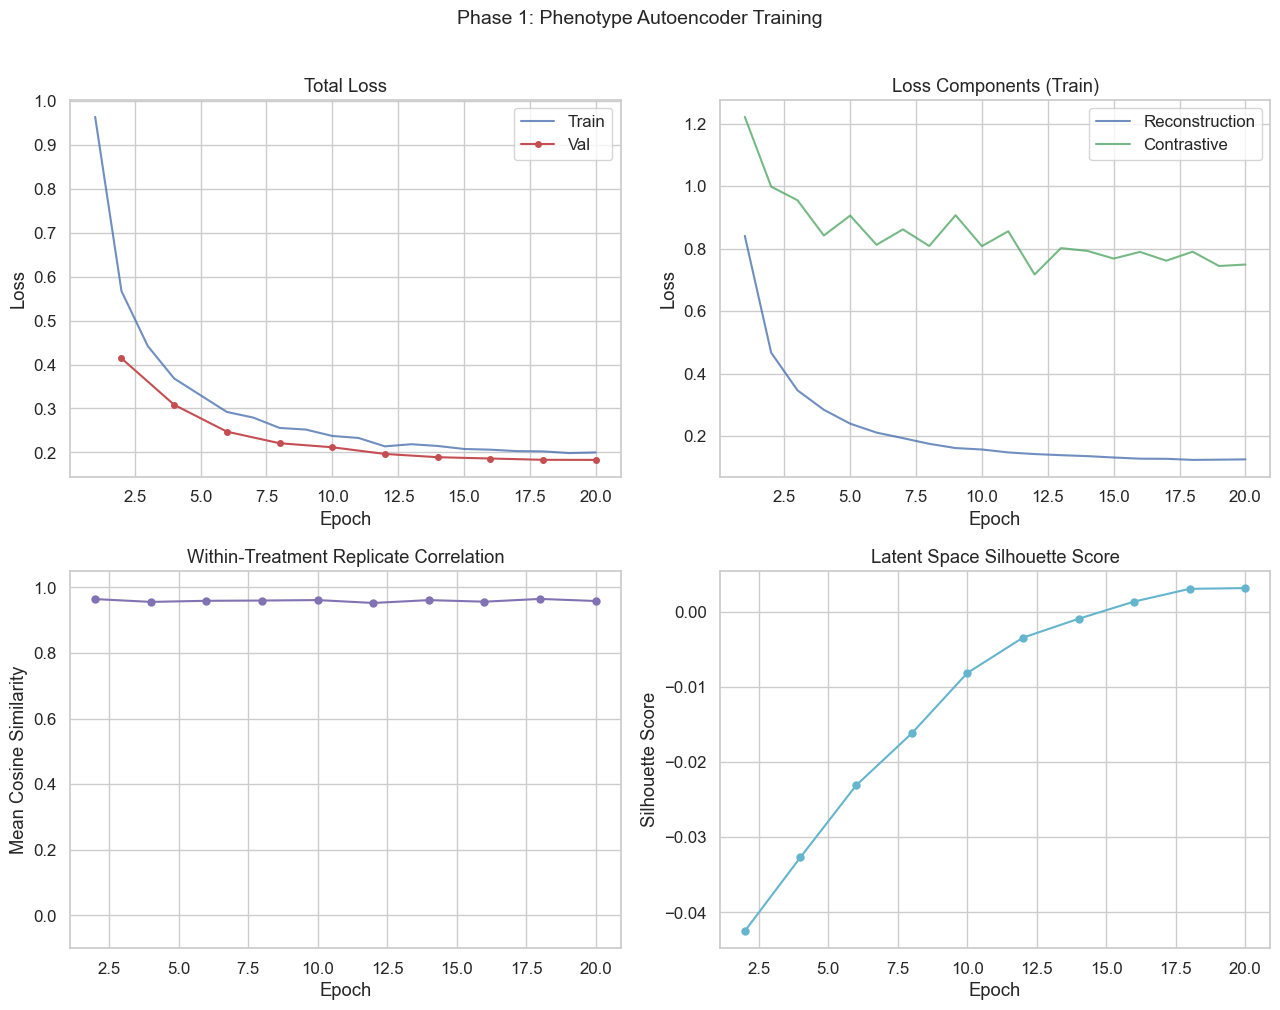

In [9]:
# --- Plot Phase 1 training curves ---
fig, axes = plt.subplots(2, 2, figsize=(13, 10))

epochs = history["epoch"]
eval_epochs = [e for e, v in zip(epochs, history["val_total"]) if not np.isnan(v)]

# Total loss
axes[0, 0].plot(epochs, history["train_total"], "b-", alpha=0.8, label="Train")
val_total_clean = [v for v in history["val_total"] if not np.isnan(v)]
axes[0, 0].plot(eval_epochs, val_total_clean, "r-o", markersize=4, label="Val")
axes[0, 0].set_xlabel("Epoch")
axes[0, 0].set_ylabel("Loss")
axes[0, 0].set_title("Total Loss")
axes[0, 0].legend()

# Reconstruction vs contrastive (train)
axes[0, 1].plot(epochs, history["train_recon"], "b-", alpha=0.8, label="Reconstruction")
axes[0, 1].plot(epochs, history["train_contrastive"], "g-", alpha=0.8, label="Contrastive")
axes[0, 1].set_xlabel("Epoch")
axes[0, 1].set_ylabel("Loss")
axes[0, 1].set_title("Loss Components (Train)")
axes[0, 1].legend()

# Replicate correlation
rep_corr_clean = [v for v in history["replicate_corr"] if not np.isnan(v)]
axes[1, 0].plot(eval_epochs, rep_corr_clean, "m-o", markersize=5)
axes[1, 0].set_xlabel("Epoch")
axes[1, 0].set_ylabel("Mean Cosine Similarity")
axes[1, 0].set_title("Within-Treatment Replicate Correlation")
axes[1, 0].set_ylim([-0.1, 1.05])

# Silhouette score
sil_clean = [v for v in history["silhouette"] if not np.isnan(v)]
axes[1, 1].plot(eval_epochs, sil_clean, "c-o", markersize=5)
axes[1, 1].set_xlabel("Epoch")
axes[1, 1].set_ylabel("Silhouette Score")
axes[1, 1].set_title("Latent Space Silhouette Score")

plt.suptitle("Phase 1: Phenotype Autoencoder Training", fontsize=14, y=1.01)
plt.tight_layout()
plt.savefig(NOTEBOOK_DIR / "phase1_training_curves.png", dpi=150, bbox_inches="tight")
plt.show()

### 3.5 Latent Space Analysis

A well-trained autoencoder should produce a latent space where:
- Replicates of the same treatment cluster together
- Different treatments separate into distinct regions
- The overall structure captures biologically meaningful variation

In [10]:
# Collect all validation latents for visualisation
autoencoder.eval()
all_latents, all_labels, all_plates = [], [], []

with torch.no_grad():
    for batch in val_loader:
        features_batch = batch["phenotype_features"].to(device)
        enc_out = autoencoder.encode(features_batch)
        all_latents.append(enc_out["latent"].cpu())
        all_labels.append(batch["treatment_label"])
        all_plates.extend(batch["plate_id"])

latents_np = torch.cat(all_latents).numpy()
labels_np = torch.cat(all_labels).numpy()
plates_np = np.array(all_plates)

print(f"Latent representations: {latents_np.shape}")
print(f"Unique treatments in val set: {len(np.unique(labels_np))}")

Latent representations: (5000, 64)
Unique treatments in val set: 3272


c:\Users\adou0002\protophen\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


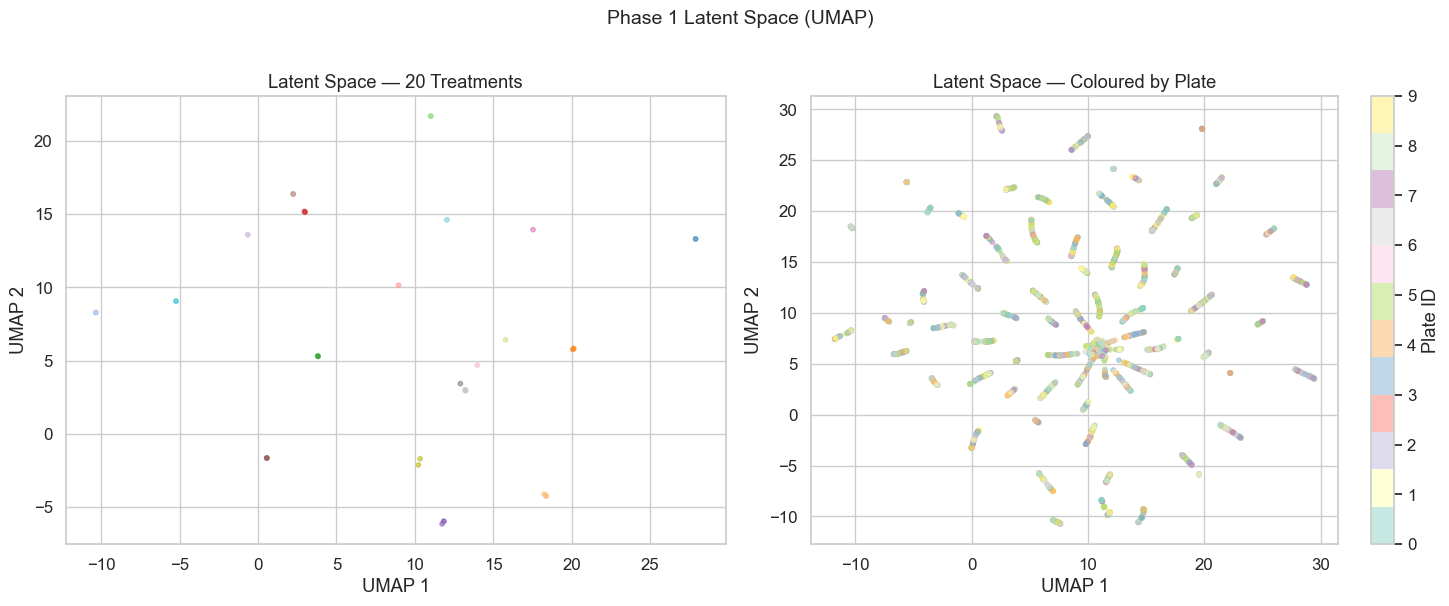

In [11]:
# UMAP dimensionality reduction
try:
    from umap import UMAP

    reducer = UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=SEED)
    latent_2d = reducer.fit_transform(latents_np)

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Colour by treatment (use first N for visibility)
    N_SHOW = min(20, len(np.unique(labels_np)))
    top_treatments = np.unique(labels_np)[:N_SHOW]
    mask = np.isin(labels_np, top_treatments)

    scatter = axes[0].scatter(
        latent_2d[mask, 0], latent_2d[mask, 1],
        c=labels_np[mask], cmap="tab20", s=10, alpha=0.6,
    )
    axes[0].set_xlabel("UMAP 1")
    axes[0].set_ylabel("UMAP 2")
    axes[0].set_title(f"Latent Space — {N_SHOW} Treatments")

    # Colour by plate
    plate_ids_numeric = np.array([int(p.split("_")[1]) for p in plates_np])
    scatter2 = axes[1].scatter(
        latent_2d[:, 0], latent_2d[:, 1],
        c=plate_ids_numeric, cmap="Set3", s=10, alpha=0.5,
    )
    axes[1].set_xlabel("UMAP 1")
    axes[1].set_ylabel("UMAP 2")
    axes[1].set_title("Latent Space — Coloured by Plate")
    plt.colorbar(scatter2, ax=axes[1], label="Plate ID")

    plt.suptitle("Phase 1 Latent Space (UMAP)", fontsize=14, y=1.01)
    plt.tight_layout()
    plt.savefig(NOTEBOOK_DIR / "phase1_umap.png", dpi=150, bbox_inches="tight")
    plt.show()

except ImportError:
    print("umap-learn not installed — skipping UMAP visualisation.")
    print("Install with: pip install umap-learn")

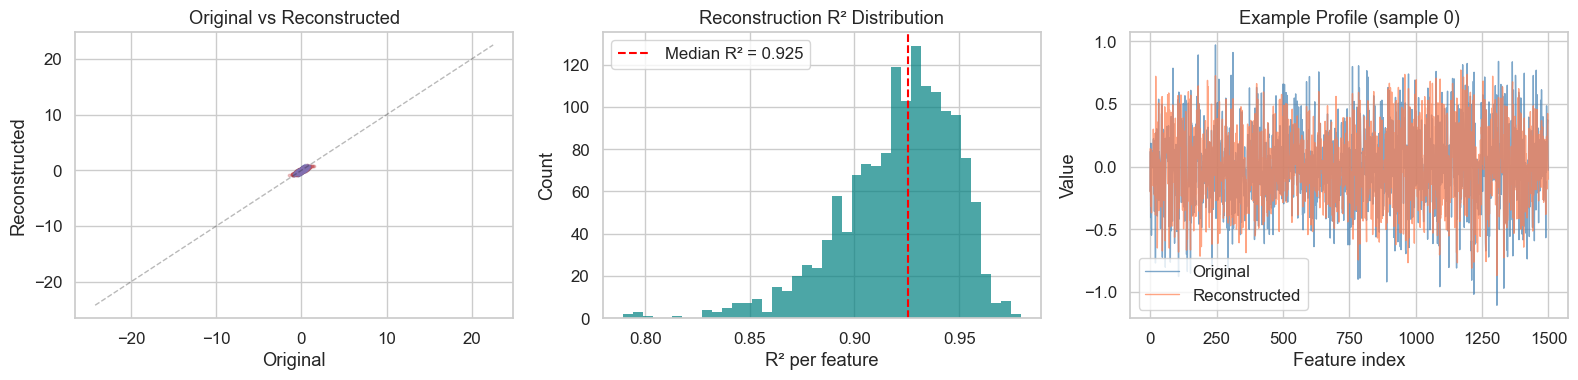

Reconstruction R²: median=0.925, mean=0.921


In [12]:
# Reconstruction quality: original vs reconstructed profiles
autoencoder.eval()
with torch.no_grad():
    sample_batch = next(iter(val_loader))
    sample_features = sample_batch["phenotype_features"].to(device)
    recon = autoencoder(sample_features)["reconstruction"].cpu().numpy()
    original = sample_features.cpu().numpy()

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Scatter: original vs reconstructed (all features, first 5 samples)
for i in range(min(5, len(original))):
    axes[0].scatter(original[i], recon[i], s=3, alpha=0.3, label=f"Sample {i}")
lims = [original.min() * 1.1, original.max() * 1.1]
axes[0].plot(lims, lims, "k--", alpha=0.3, linewidth=1)
axes[0].set_xlabel("Original")
axes[0].set_ylabel("Reconstructed")
axes[0].set_title("Original vs Reconstructed")

# Per-feature R²
from sklearn.metrics import r2_score
per_feature_r2 = []
for j in range(original.shape[1]):
    r2 = r2_score(original[:, j], recon[:, j])
    per_feature_r2.append(r2)
per_feature_r2 = np.array(per_feature_r2)

axes[1].hist(per_feature_r2, bins=40, color="teal", alpha=0.7, edgecolor="none")
axes[1].axvline(np.median(per_feature_r2), color="red", linestyle="--",
                label=f"Median R² = {np.median(per_feature_r2):.3f}")
axes[1].set_xlabel("R² per feature")
axes[1].set_ylabel("Count")
axes[1].set_title("Reconstruction R² Distribution")
axes[1].legend()

# Example profile: original vs reconstructed
idx = 0
axes[2].plot(original[idx], color="steelblue", alpha=0.7, label="Original", linewidth=1)
axes[2].plot(recon[idx], color="coral", alpha=0.7, label="Reconstructed", linewidth=1)
axes[2].set_xlabel("Feature index")
axes[2].set_ylabel("Value")
axes[2].set_title(f"Example Profile (sample {idx})")
axes[2].legend()

plt.tight_layout()
plt.savefig(NOTEBOOK_DIR / "phase1_reconstruction.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"Reconstruction R²: median={np.median(per_feature_r2):.3f}, "
      f"mean={np.mean(per_feature_r2):.3f}")

### 3.6 Save Phase 1 Checkpoint

In production, `scripts/pretrain_phenotype.py` saves checkpoints automatically.
Here we save one manually so Phase 2 can load it.

In [13]:
# Update config to match our demo dimensions
demo_config = PretrainingConfig()
demo_config.autoencoder = ae_config

phase1_ckpt_path = NOTEBOOK_DIR / "phase1_demo.pt"
save_phase1_checkpoint(
    path=phase1_ckpt_path,
    autoencoder=autoencoder,
    config=demo_config,
    epoch=NUM_EPOCHS,
    global_step=len(train_loader) * NUM_EPOCHS,
    best_val_loss=float(val_total_clean[-1]) if val_total_clean else float("inf"),
)
print(f"Phase 1 checkpoint saved to {phase1_ckpt_path}")

2026-02-21 20:47:33 | INFO     | protophen.models.autoencoder:save_phase1_checkpoint:1708 | Phase 1 checkpoint saved to data\notebook_06\phase1_demo.pt


Phase 1 checkpoint saved to data\notebook_06\phase1_demo.pt


## 4. Phase 2: Protein→Phenotype Mapping

Phase 2 loads the Phase 1 autoencoder, freezes the decoder, and trains a
protein encoder to predict the autoencoder's latent representation from
ESM-2 protein embeddings.

By training through the frozen decoder, the protein encoder must learn to 
produce latent vectors that decode into realistic Cell Painting profiles. The decoder acts as a "biological reality filter".

In production, this runs via `scripts/pretrain_mapping.py` on ORF/CRISPR data.
Here we demonstrate with synthetic protein embeddings.

### 4.1 Load Phase 1 Checkpoint & Build Phase 2 Model

In [14]:
# Load the Phase 1 autoencoder
loaded_ae, phase1_ckpt = load_autoencoder_from_checkpoint(
    phase1_ckpt_path, device=device,
)
print(f"Loaded autoencoder: latent_dim={loaded_ae.latent_dim}, "
      f"input_dim={loaded_ae.input_dim}")

2026-02-21 20:47:33 | INFO     | protophen.models.autoencoder:__init__:462 | PhenotypeAutoencoder initialised: input_dim=1500, latent_dim=64, variational=False, skip_connections=False, params=423,900
2026-02-21 20:47:33 | INFO     | protophen.models.autoencoder:load_autoencoder_from_checkpoint:1815 | Loaded Phase 1 autoencoder from data\notebook_06\phase1_demo.pt (epoch 20)


Loaded autoencoder: latent_dim=64, input_dim=1500


In [15]:
# Build ProToPhenModel with frozen autoencoder decoder
PROTEIN_EMBEDDING_DIM = 128  # small for demo (real ESM-2 = 1280)

model_config = ProToPhenConfig(
    protein_embedding_dim=PROTEIN_EMBEDDING_DIM,
    encoder_hidden_dims=[96, 80],      # small for demo
    encoder_output_dim=loaded_ae.latent_dim,  # must match autoencoder latent
    cell_painting_dim=loaded_ae.input_dim,
    predict_viability=False,
    predict_transcriptomics=False,
)

model = ProToPhenModel(model_config)

# Replace cell_painting decoder with frozen autoencoder decoder
decoder_head = loaded_ae.get_decoder_head(freeze=True)
model.decoders["cell_painting"] = decoder_head
model = model.to(device)

# Verify parameter freeze status
n_total = sum(p.numel() for p in model.parameters())
n_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
n_frozen = n_total - n_trainable

print(f"\nPhase 2 Model:")
print(f"  Total parameters:     {n_total:,}")
print(f"  Trainable (encoder):  {n_trainable:,}")
print(f"  Frozen (decoder):     {n_frozen:,}")
print(f"  Trainable fraction:   {n_trainable / n_total:.1%}")
print(f"\n  Encoder output dim:   {model_config.encoder_output_dim}")
print(f"  Decoder input dim:    {decoder_head.latent_dim}")
print(f"  Decoder output dim:   {decoder_head.output_dim}")

# Verify dimensions match
assert model_config.encoder_output_dim == decoder_head.latent_dim, \
    "Encoder output must match decoder latent dim!"
print("\n✓ Dimension check passed")


2026-02-21 20:47:33 | INFO     | protophen.models.protophen:__init__:170 | Initialised ProToPhenModel: 2,124,972 parameters, tasks=['cell_painting']
2026-02-21 20:47:33 | INFO     | protophen.models.autoencoder:__init__:888 | AutoencoderDecoderHead: all parameters frozen (212,604 params)



Phase 2 Model:
  Total parameters:     238,412
  Trainable (encoder):  25,808
  Frozen (decoder):     212,604
  Trainable fraction:   10.8%

  Encoder output dim:   64
  Decoder input dim:    64
  Decoder output dim:   1500

✓ Dimension check passed


### 4.2 Create Synthetic Phase 2 Data

In production, Phase 2 data consists of:
- **Protein embeddings**: ESM-2 representations of genes from ORF/CRISPR plates
- **Cell Painting features**: normalised profiles for those genes

Here we create synthetic protein embeddings that have a learnable relationship
to the phenotype features generated in Phase 1.

In [16]:
# --- Structured Phase 2 synthetic data ---
# Mirrors the generative process from Phase 1 but for genetic perturbations:
#   • Protein embeddings cluster by pathway (analogous to MoA clusters)
#   • Ground-truth linear mapping from protein space → phenotype latent space
#   • Heavy-tailed per-gene effect magnitudes
#   • Same block-structured factor loadings, noise model, and transforms

N_GENES = 300
WELLS_PER_GENE = 5
N_PHASE2_SAMPLES = N_GENES * WELLS_PER_GENE

print(f"Generating structured Phase 2 data: {N_GENES} genes × "
      f"{WELLS_PER_GENE} wells = {N_PHASE2_SAMPLES} samples")

# ── 1. Ground-truth protein → latent mapping ────────────────────────
# This is what Phase 2 must learn: protein sequence determines phenotype.
# Linear mapping with moderate weight scale — keeps latent codes in a
# similar range to Phase 1 treatment centres.
protein_to_latent_map = rng.standard_normal(
    (PROTEIN_EMBEDDING_DIM, n_latent)
).astype(np.float32) * 0.3

# ── 2. Protein embeddings with pathway/functional cluster structure ──
# Genes in the same pathway produce similar embeddings (and therefore
# similar phenotypes), mirroring real biology where functionally related
# proteins yield correlated Cell Painting profiles.
n_pathways = 30
gene_pathway_ids = rng.integers(0, n_pathways, size=N_GENES)
pathway_protein_centres = rng.standard_normal(
    (n_pathways, PROTEIN_EMBEDDING_DIM)
).astype(np.float32) * 1.0

# Each gene's embedding = pathway centre + gene-specific variation
gene_protein_embs = (
    pathway_protein_centres[gene_pathway_ids]
    + rng.standard_normal((N_GENES, PROTEIN_EMBEDDING_DIM)).astype(np.float32) * 0.5
)

# ── 3. Heavy-tailed per-gene effect magnitudes ──────────────────────
# Most knockouts/overexpressions produce subtle phenotypes; a few are
# dramatic — matching the heavy-tailed effect distribution in Phase 1.
gene_effect_magnitudes = np.abs(
    rng.standard_t(df=3, size=N_GENES)
).astype(np.float32)

# ── 4. Compute gene-level latent centres ────────────────────────────
# The "true" phenotype for each gene is determined by its protein
# embedding projected through the ground-truth mapping, scaled by
# the gene's effect magnitude.
gene_latent_centres = (
    gene_protein_embs @ protein_to_latent_map
    * gene_effect_magnitudes[:, None]
)

# ── 5. Generate replicate samples (vectorised) ──────────────────────
sample_gene_idx = np.repeat(np.arange(N_GENES), WELLS_PER_GENE)

# Replicate-level latent codes: gene centre + biological noise
# (noise scale 0.3 matches Phase 1 replicate noise)
z_p2 = (
    gene_latent_centres[sample_gene_idx]
    + rng.standard_normal((N_PHASE2_SAMPLES, n_latent)).astype(np.float32) * 0.3
)

# Project through the SAME block-structured factor loadings as Phase 1
# (W is the shared generative model — both phases live on the same manifold)
p2_features_raw = z_p2 @ W.T

# Same heteroscedastic observation noise (scaled by per-feature variance)
p2_features_raw += (
    rng.standard_normal(p2_features_raw.shape).astype(np.float32)
    * 0.2 * feature_scales[None, :]
)

# ── 6. Apply same non-Gaussian transforms to same features ──────────
# The heavy-tail mask from Phase 1 ensures identical marginal transforms
for j in np.where(heavy_tail_mask)[0]:
    p2_features_raw[:, j] = (
        np.sign(p2_features_raw[:, j])
        * np.abs(p2_features_raw[:, j]) ** 1.3
    )

# ── 7. Standardise using Phase 1 statistics ─────────────────────────
# Critical: Phase 2 features must be on the same scale as Phase 1.
# In real workflows this is analogous to normalising against plate-level
# DMSO controls computed from Phase 1 reference data.
p2_features = (
    (p2_features_raw - p1_feature_mean) / (p1_feature_std + 1e-8)
).astype(np.float32)

# ── 8. Expand protein embeddings to per-replicate arrays ────────────
p2_embeddings = gene_protein_embs[sample_gene_idx].astype(np.float32)
p2_ids = [f"gene_{g:04d}" for g in sample_gene_idx]

print(f"Protein embeddings: {p2_embeddings.shape}")
print(f"Phenotype features: {p2_features.shape}")
print(f"Pathway clusters:   {n_pathways}")
print(f"Effect magnitude:   median={np.median(gene_effect_magnitudes):.2f}, "
      f"max={gene_effect_magnitudes.max():.2f}")

# ── Pre-compute target latents using Phase 1 encoder ────────────────
# These become training targets for the latent-space loss approach (Model A)
loaded_ae.eval()
with torch.no_grad():
    _latent_chunks = []
    _batch_size = 512
    _p2_tensor = torch.from_numpy(p2_features).float().to(device)
    for _i in range(0, len(_p2_tensor), _batch_size):
        _chunk = _p2_tensor[_i : _i + _batch_size]
        _enc = loaded_ae.encode(_chunk)
        _latent_chunks.append(_enc["latent"].cpu())
    target_latents = torch.cat(_latent_chunks).numpy()
    del _p2_tensor, _latent_chunks

print(f"Pre-computed target latents: {target_latents.shape}")
print(f"Latent range: [{target_latents.min():.3f}, {target_latents.max():.3f}]")

# Keep a reference to the decoder for inference-time decoding (Model A)
phase1_decoder_state = {
    k: v.clone() for k, v in loaded_ae.state_dict().items()
}
ae_config_for_decode = loaded_ae.config

# Create ProtoPhenDataset
p2_dataset = ProtoPhenDataset.from_arrays(
    protein_embeddings=p2_embeddings,
    phenotype_features=p2_features,
    protein_ids=p2_ids,
)

# Split (ProtoPhenDataset.split() returns train, val, test)
p2_train, p2_val, _ = p2_dataset.split(
    train_frac=0.8, val_frac=0.2, test_frac=0.0, seed=SEED,
)

print(f"\nPhase 2 split: {len(p2_train)} train, {len(p2_val)} val")

# Free standalone autoencoder (weights now live inside the decoder head)
del loaded_ae

2026-02-21 20:47:33 | INFO     | protophen.data.dataset:split:563 | Split dataset: train=1200, val=300, test=0


Generating structured Phase 2 data: 300 genes × 5 wells = 1500 samples
Protein embeddings: (1500, 128)
Phenotype features: (1500, 1500)
Pathway clusters:   30
Effect magnitude:   median=0.68, max=7.11
Pre-computed target latents: (1500, 64)
Latent range: [-4.470, 4.464]

Phase 2 split: 1200 train, 300 val


### 4.3 Phase 2 Training — Three-Way Comparison

We compare three approaches:

| Model | Training target | Decoder during training | Decoder at inference |
|-------|----------------|------------------------|---------------------|
| **A: Latent-space** | MSE(pred_latent, ae_latent) | Not used | Phase 1 (frozen) |
| **B: Frozen-decoder** | MSE(decoded_features, true_features) | Phase 1 (frozen) | Phase 1 (frozen) |
| **C: Baseline** | MSE(pred_features, true_features) | Random (trainable) | Same (trained) |


In [17]:
# --- Common setup ---

def p2_collate_fn(batch):
    result = {}
    for key in batch[0]:
        values = [b[key] for b in batch]
        if isinstance(values[0], torch.Tensor):
            result[key] = torch.stack(values)
        else:
            result[key] = values
    return result

p2_train_loader = DataLoader(
    p2_train, batch_size=64, shuffle=True, drop_last=True,
    collate_fn=p2_collate_fn,
)
p2_val_loader = DataLoader(
    p2_val, batch_size=128, shuffle=False, collate_fn=p2_collate_fn,
)

P2_EPOCHS = 15
P2_LR = 1e-3

# We need the train/val index split to align target_latents
# Reconstruct indices from the protein_ids
_train_ids = [s.protein_id for s in p2_train.samples]
_val_ids = [s.protein_id for s in p2_val.samples]

# Build id→row mapping from the original p2_dataset
_all_ids = [s.protein_id for s in p2_dataset.samples]
_id_to_rows = defaultdict(list)
for _row, _pid in enumerate(_all_ids):
    _id_to_rows[_pid].append(_row)

# Map each sample in train/val back to its original row index
# (ProtoPhenDataset.split shuffles but preserves sample objects)
_train_latent_list = []
for _s in p2_train.samples:
    _row = _id_to_rows[_s.protein_id].pop(0)
    _train_latent_list.append(target_latents[_row])

# Reset for val
_id_to_rows_v = defaultdict(list)
for _row, _pid in enumerate(_all_ids):
    _id_to_rows_v[_pid].append(_row)
# Skip rows already consumed by train
_consumed = set()
_val_latent_list = []
for _s in p2_val.samples:
    for _row in _id_to_rows_v[_s.protein_id]:
        if _row not in _consumed:
            _val_latent_list.append(target_latents[_row])
            _consumed.add(_row)
            break

train_target_latents_t = torch.from_numpy(np.stack(_train_latent_list)).float()
val_target_latents_t = torch.from_numpy(np.stack(_val_latent_list)).float()
print(f"Latent targets: train={train_target_latents_t.shape}, val={val_target_latents_t.shape}")

# %%
# --- Model A: Latent-space loss (custom loop) ---
from protophen.models.encoders import ProteinEncoder, ProteinEncoderConfig

encoder_a_config = ProteinEncoderConfig(
    input_dim=PROTEIN_EMBEDDING_DIM,
    hidden_dims=[96, 80],
    output_dim=loaded_ae.latent_dim if 'loaded_ae' in dir() else ae_config_for_decode.latent_dim,
    activation="gelu",
    dropout=0.1,
)
encoder_a = ProteinEncoder(encoder_a_config).to(device)

opt_a = torch.optim.AdamW(encoder_a.parameters(), lr=P2_LR, weight_decay=0.01)
sched_a = torch.optim.lr_scheduler.CosineAnnealingLR(
    opt_a, T_max=len(p2_train_loader) * P2_EPOCHS, eta_min=1e-6,
)

history_a = {"train_loss": [], "val_loss": []}

# Pair each DataLoader batch with the corresponding target latents
# Since DataLoader with shuffle=True reorders, we need index tracking.
# Simpler approach: build a parallel tensor dataset.
from torch.utils.data import TensorDataset

_train_embs = torch.from_numpy(
    np.stack([s.protein_embedding for s in p2_train.samples])
).float()
_train_feats = torch.from_numpy(
    np.stack([s.phenotypes["cell_painting"] for s in p2_train.samples])
).float()
_val_embs = torch.from_numpy(
    np.stack([s.protein_embedding for s in p2_val.samples])
).float()
_val_feats = torch.from_numpy(
    np.stack([s.phenotypes["cell_painting"] for s in p2_val.samples])
).float()

train_tensor_ds = TensorDataset(_train_embs, _train_feats, train_target_latents_t)
val_tensor_ds = TensorDataset(_val_embs, _val_feats, val_target_latents_t)

train_loader_a = DataLoader(train_tensor_ds, batch_size=64, shuffle=True, drop_last=True)
val_loader_a = DataLoader(val_tensor_ds, batch_size=128, shuffle=False)

print(f"Model A (latent-space): {sum(p.numel() for p in encoder_a.parameters()):,} params")

import torch.nn.functional as F

for epoch in range(1, P2_EPOCHS + 1):
    encoder_a.train()
    _losses = []
    for emb_b, _, lat_b in train_loader_a:
        emb_b, lat_b = emb_b.to(device), lat_b.to(device)
        pred_lat = encoder_a(emb_b)
        loss = F.mse_loss(pred_lat, lat_b)
        opt_a.zero_grad()
        loss.backward()
        clip_grad_norm_(encoder_a.parameters(), 1.0)
        opt_a.step()
        sched_a.step()
        _losses.append(loss.item())
    history_a["train_loss"].append(np.mean(_losses))

    encoder_a.eval()
    _vlosses = []
    with torch.no_grad():
        for emb_b, _, lat_b in val_loader_a:
            emb_b, lat_b = emb_b.to(device), lat_b.to(device)
            pred_lat = encoder_a(emb_b)
            _vlosses.append(F.mse_loss(pred_lat, lat_b).item())
    history_a["val_loss"].append(np.mean(_vlosses))

    if epoch % 5 == 0 or epoch == P2_EPOCHS:
        print(f"  A epoch {epoch:>2d}: train={history_a['train_loss'][-1]:.4f}, "
              f"val={history_a['val_loss'][-1]:.4f}")

print("Model A training complete.")

# %%
# --- Model B: Frozen-decoder pretrained (Trainer) ---
model_b_config = ProToPhenConfig(
    protein_embedding_dim=PROTEIN_EMBEDDING_DIM,
    encoder_hidden_dims=[96, 80],
    encoder_output_dim=ae_config_for_decode.latent_dim,
    cell_painting_dim=ae_config_for_decode.input_dim,
    predict_viability=False,
    predict_transcriptomics=False,
)
model_b = ProToPhenModel(model_b_config)

# Rebuild autoencoder just for the decoder head
_ae_tmp = PhenotypeAutoencoder(ae_config_for_decode)
_ae_tmp.load_state_dict(phase1_decoder_state)
model_b.decoders["cell_painting"] = _ae_tmp.get_decoder_head(freeze=True)
del _ae_tmp
model_b = model_b.to(device)

n_b_train = sum(p.numel() for p in model_b.parameters() if p.requires_grad)
print(f"Model B (frozen-decoder): {n_b_train:,} trainable params")

trainer_config_b = TrainerConfig(
    epochs=P2_EPOCHS, learning_rate=P2_LR, weight_decay=0.01,
    optimiser="adamw", scheduler="cosine",
    warmup_steps=len(p2_train_loader) * 2, min_lr=1e-6,
    max_grad_norm=1.0, use_amp=False, device=str(device),
    seed=SEED, tasks=["cell_painting"], task_weights={"cell_painting": 1.0},
    eval_every_n_epochs=1,
)
trainer_b = Trainer(
    model=model_b, train_loader=p2_train_loader, val_loader=p2_val_loader,
    config=trainer_config_b, callbacks=[LoggingCallback(log_every_n_steps=999)],
)
history_b = trainer_b.train()
print(f"Model B best val loss: {history_b['best_val_loss']:.4f}")

# %%
# --- Model C: Baseline (no pretraining, trainable decoder) ---
model_c = ProToPhenModel(model_b_config).to(device)

n_c_train = sum(p.numel() for p in model_c.parameters() if p.requires_grad)
print(f"Model C (baseline): {n_c_train:,} trainable params")

trainer_c = Trainer(
    model=model_c, train_loader=p2_train_loader, val_loader=p2_val_loader,
    config=trainer_config_b, callbacks=[LoggingCallback(log_every_n_steps=999)],
)
history_c = trainer_c.train()
print(f"Model C best val loss: {history_c['best_val_loss']:.4f}")

Latent targets: train=torch.Size([1200, 64]), val=torch.Size([300, 64])
Model A (latent-space): 25,808 params
  A epoch  5: train=0.7547, val=0.6433
  A epoch 10: train=0.5703, val=0.4892


2026-02-21 20:47:34 | INFO     | protophen.models.protophen:__init__:170 | Initialised ProToPhenModel: 2,124,972 parameters, tasks=['cell_painting']
2026-02-21 20:47:34 | INFO     | protophen.models.autoencoder:__init__:462 | PhenotypeAutoencoder initialised: input_dim=1500, latent_dim=64, variational=False, skip_connections=False, params=423,900
2026-02-21 20:47:34 | INFO     | protophen.models.autoencoder:__init__:888 | AutoencoderDecoderHead: all parameters frozen (212,604 params)
2026-02-21 20:47:34 | INFO     | protophen.training.trainer:__init__:230 | Trainer initialised: device=cuda, epochs=15, lr=0.001, amp=False
2026-02-21 20:47:34 | INFO     | protophen.training.trainer:train:654 | Starting training for 15 epochs


  A epoch 15: train=0.5363, val=0.4685
Model A training complete.
Model B (frozen-decoder): 25,808 trainable params


2026-02-21 20:47:34 | INFO     | protophen.training.callbacks:on_validation_end:523 | Validation | cell_painting_mse: 5.8443 | cell_painting_mae: 1.1987 | cell_painting_rmse: 2.4175 | cell_painting_r2: -0.0125 | cell_painting_pearson: 0.0174 | cell_painting_cosine_similarity: 0.0170 | val_loss: 6.6649
2026-02-21 20:47:34 | INFO     | protophen.training.callbacks:on_epoch_end:509 | Epoch 1 completed in 0.3s | Avg Loss: 7.3894
2026-02-21 20:47:35 | INFO     | protophen.training.callbacks:on_validation_end:523 | Validation | cell_painting_mse: 5.7561 | cell_painting_mae: 1.1559 | cell_painting_rmse: 2.3992 | cell_painting_r2: 0.0028 | cell_painting_pearson: 0.1100 | cell_painting_cosine_similarity: 0.1101 | val_loss: 6.5763
2026-02-21 20:47:35 | INFO     | protophen.training.callbacks:on_epoch_end:509 | Epoch 2 completed in 0.2s | Avg Loss: 6.7671
2026-02-21 20:47:35 | INFO     | protophen.training.callbacks:on_validation_end:523 | Validation | cell_painting_mse: 5.7188 | cell_painting_ma

Model B best val loss: 5.8147
Model C (baseline): 2,124,972 trainable params


2026-02-21 20:47:38 | INFO     | protophen.training.callbacks:on_validation_end:523 | Validation | cell_painting_mse: 5.3671 | cell_painting_mae: 1.1556 | cell_painting_rmse: 2.3167 | cell_painting_r2: 0.0702 | cell_painting_pearson: 0.3617 | cell_painting_cosine_similarity: 0.3619 | val_loss: 6.1264
2026-02-21 20:47:38 | INFO     | protophen.training.callbacks:on_epoch_end:509 | Epoch 1 completed in 0.4s | Avg Loss: 6.4833
2026-02-21 20:47:38 | INFO     | protophen.training.callbacks:on_validation_end:523 | Validation | cell_painting_mse: 4.2972 | cell_painting_mae: 1.0926 | cell_painting_rmse: 2.0730 | cell_painting_r2: 0.2555 | cell_painting_pearson: 0.6548 | cell_painting_cosine_similarity: 0.6547 | val_loss: 4.8412
2026-02-21 20:47:38 | INFO     | protophen.training.callbacks:on_epoch_end:509 | Epoch 2 completed in 0.3s | Avg Loss: 5.7610
2026-02-21 20:47:39 | INFO     | protophen.training.callbacks:on_validation_end:523 | Validation | cell_painting_mse: 3.7674 | cell_painting_mae

Model C best val loss: 2.3408


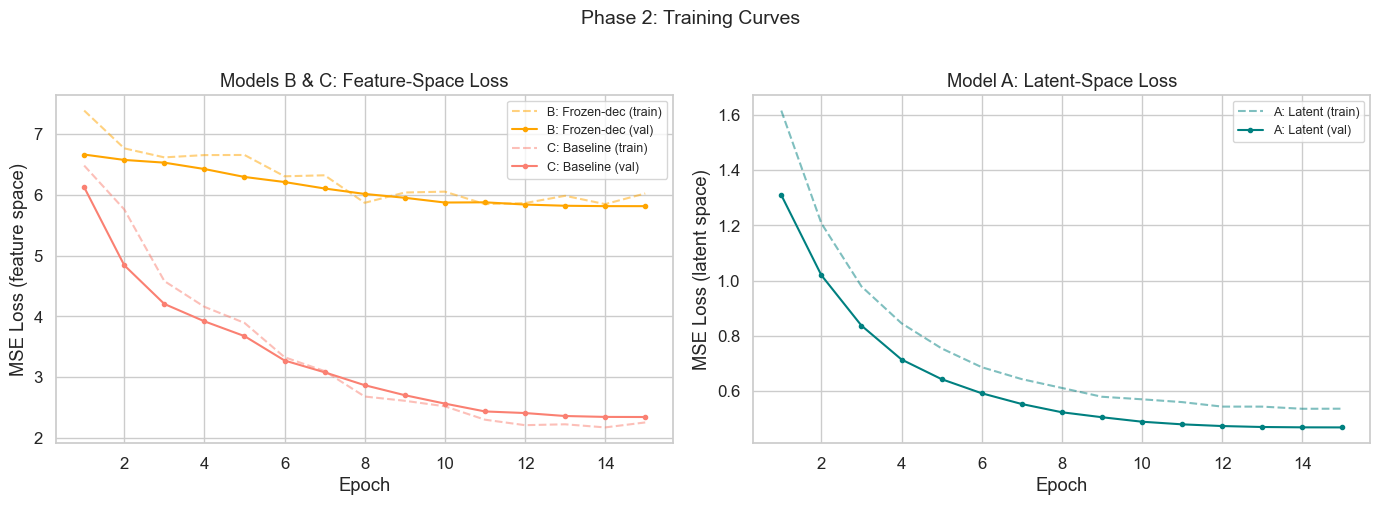

In [18]:
# Plot Phase 2 training curves — all three models
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left panel: Feature-space loss (Models B and C)
ax = axes[0]
if history_b["val_losses"]:
    ax.plot(range(1, len(history_b["train_losses"]) + 1),
            history_b["train_losses"], "orange", alpha=0.5, linestyle="--", label="B: Frozen-dec (train)")
    ax.plot(range(1, len(history_b["val_losses"]) + 1),
            history_b["val_losses"], "orange", marker="o", markersize=3, label="B: Frozen-dec (val)")
if history_c["val_losses"]:
    ax.plot(range(1, len(history_c["train_losses"]) + 1),
            history_c["train_losses"], "salmon", alpha=0.5, linestyle="--", label="C: Baseline (train)")
    ax.plot(range(1, len(history_c["val_losses"]) + 1),
            history_c["val_losses"], "salmon", marker="o", markersize=3, label="C: Baseline (val)")
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE Loss (feature space)")
ax.set_title("Models B & C: Feature-Space Loss")
ax.legend(fontsize=9)

# Right panel: Latent-space loss (Model A)
ax2 = axes[1]
ax2.plot(range(1, P2_EPOCHS + 1),
         history_a["train_loss"], "teal", alpha=0.5, linestyle="--", label="A: Latent (train)")
ax2.plot(range(1, P2_EPOCHS + 1),
         history_a["val_loss"], "teal", marker="o", markersize=3, label="A: Latent (val)")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("MSE Loss (latent space)")
ax2.set_title("Model A: Latent-Space Loss")
ax2.legend(fontsize=9)

plt.suptitle("Phase 2: Training Curves", fontsize=14, y=1.01)
plt.tight_layout()
plt.savefig(NOTEBOOK_DIR / "phase2_training_curves.png", dpi=150, bbox_inches="tight")
plt.show()

### 4.4 Evaluation: Three-Way Comparison

In [19]:
# --- Evaluate all three models in feature space ---
from sklearn.metrics import r2_score

def evaluate_in_feature_space(pred_features, true_features, label):
    """Compute per-feature R² and overall R²."""
    per_r2 = np.array([
        r2_score(true_features[:, j], pred_features[:, j])
        for j in range(true_features.shape[1])
    ])
    overall = r2_score(true_features.flatten(), pred_features.flatten())
    print(f"  {label}: overall_R²={overall:.4f}, median_per_feature={np.median(per_r2):.4f}, "
          f"features_R²>0.5={(per_r2>0.5).sum()}/{len(per_r2)}")
    return per_r2, overall

# Ground truth features from validation set
val_true = _val_feats.numpy()

# --- Model A: encode → decode ---
# Rebuild decoder for inference
_ae_decode = PhenotypeAutoencoder(ae_config_for_decode).to(device)
_ae_decode.load_state_dict(phase1_decoder_state)
_ae_decode.eval()

encoder_a.eval()
with torch.no_grad():
    _pred_latents = encoder_a(_val_embs.to(device))
    _pred_features_a = _ae_decode.decode(_pred_latents).cpu().numpy()
del _ae_decode

r2_a, overall_a = evaluate_in_feature_space(_pred_features_a, val_true, "Model A (latent-space)")

# --- Model B: frozen decoder ---
model_b.eval()
_preds_b = []
with torch.no_grad():
    for batch in p2_val_loader:
        emb = batch["protein_embedding"].to(device)
        _preds_b.append(model_b(emb, tasks=["cell_painting"])["cell_painting"].cpu().numpy())
pred_features_b = np.concatenate(_preds_b)
r2_b, overall_b = evaluate_in_feature_space(pred_features_b, val_true, "Model B (frozen-decoder)")

# --- Model C: baseline ---
model_c.eval()
_preds_c = []
with torch.no_grad():
    for batch in p2_val_loader:
        emb = batch["protein_embedding"].to(device)
        _preds_c.append(model_c(emb, tasks=["cell_painting"])["cell_painting"].cpu().numpy())
pred_features_c = np.concatenate(_preds_c)
r2_c, overall_c = evaluate_in_feature_space(pred_features_c, val_true, "Model C (baseline)")

2026-02-21 20:47:42 | INFO     | protophen.models.autoencoder:__init__:462 | PhenotypeAutoencoder initialised: input_dim=1500, latent_dim=64, variational=False, skip_connections=False, params=423,900


  Model A (latent-space): overall_R²=0.0155, median_per_feature=0.0040, features_R²>0.5=0/1500
  Model B (frozen-decoder): overall_R²=0.1202, median_per_feature=0.0995, features_R²>0.5=0/1500
  Model C (baseline): overall_R²=0.6504, median_per_feature=0.6559, features_R²>0.5=1434/1500


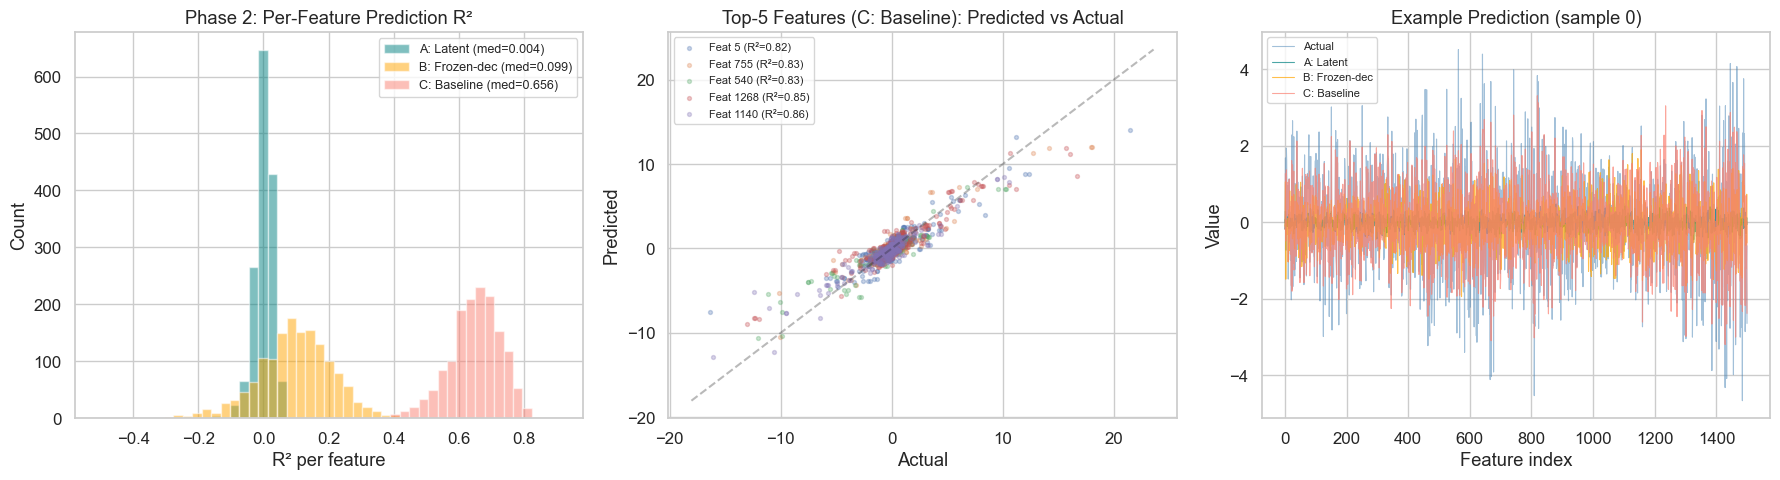

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Per-feature R² histogram — all three models
bins_hist = np.linspace(
    min(r2_a.min(), r2_b.min(), r2_c.min()) - 0.05,
    max(r2_a.max(), r2_b.max(), r2_c.max()) + 0.05,
    50,
)
axes[0].hist(r2_a, bins=bins_hist, alpha=0.5, color="teal",
             label=f"A: Latent (med={np.median(r2_a):.3f})")
axes[0].hist(r2_b, bins=bins_hist, alpha=0.5, color="orange",
             label=f"B: Frozen-dec (med={np.median(r2_b):.3f})")
axes[0].hist(r2_c, bins=bins_hist, alpha=0.5, color="salmon",
             label=f"C: Baseline (med={np.median(r2_c):.3f})")
axes[0].set_xlabel("R² per feature")
axes[0].set_ylabel("Count")
axes[0].set_title("Phase 2: Per-Feature Prediction R²")
axes[0].legend(fontsize=9)

# Scatter: predicted vs actual for best model's top-5 features
# Use whichever model has the best median R²
best_r2, best_pred, best_label = max(
    [(r2_a, _pred_features_a, "A: Latent"),
     (r2_b, pred_features_b, "B: Frozen-dec"),
     (r2_c, pred_features_c, "C: Baseline")],
    key=lambda x: np.median(x[0]),
)
top5 = np.argsort(best_r2)[-5:]
for j in top5:
    axes[1].scatter(val_true[:, j], best_pred[:, j],
                    s=8, alpha=0.3, label=f"Feat {j} (R²={best_r2[j]:.2f})")
lims = [val_true[:, top5].min() * 1.1, val_true[:, top5].max() * 1.1]
axes[1].plot(lims, lims, "k--", alpha=0.3)
axes[1].set_xlabel("Actual")
axes[1].set_ylabel("Predicted")
axes[1].set_title(f"Top-5 Features ({best_label}): Predicted vs Actual")
axes[1].legend(fontsize=8)

# Example profile — all three models overlaid
idx = 0
axes[2].plot(val_true[idx], color="steelblue", alpha=0.5,
             label="Actual", linewidth=0.8)
axes[2].plot(_pred_features_a[idx], color="teal", alpha=0.7,
             label="A: Latent", linewidth=0.8)
axes[2].plot(pred_features_b[idx], color="orange", alpha=0.7,
             label="B: Frozen-dec", linewidth=0.8)
axes[2].plot(pred_features_c[idx], color="salmon", alpha=0.7,
             label="C: Baseline", linewidth=0.8)
axes[2].set_xlabel("Feature index")
axes[2].set_ylabel("Value")
axes[2].set_title(f"Example Prediction (sample {idx})")
axes[2].legend(fontsize=8)

plt.tight_layout()
plt.savefig(NOTEBOOK_DIR / "phase2_predictions.png", dpi=150, bbox_inches="tight")
plt.show()

### 4.5 Three-Way Comparison

To demonstrate the benefit of pre-training, we train an identical model
architecture *without* the Phase 1 pre-trained decoder and compare.


Model                            Overall R²    Median R²     R²>0.5
------------------------------------------------------------------
A: Latent-space pretrained           0.0155       0.0040          0
B: Frozen-decoder pretrained         0.1202       0.0995          0
C: Baseline (no pretraining)         0.6504       0.6559       1434


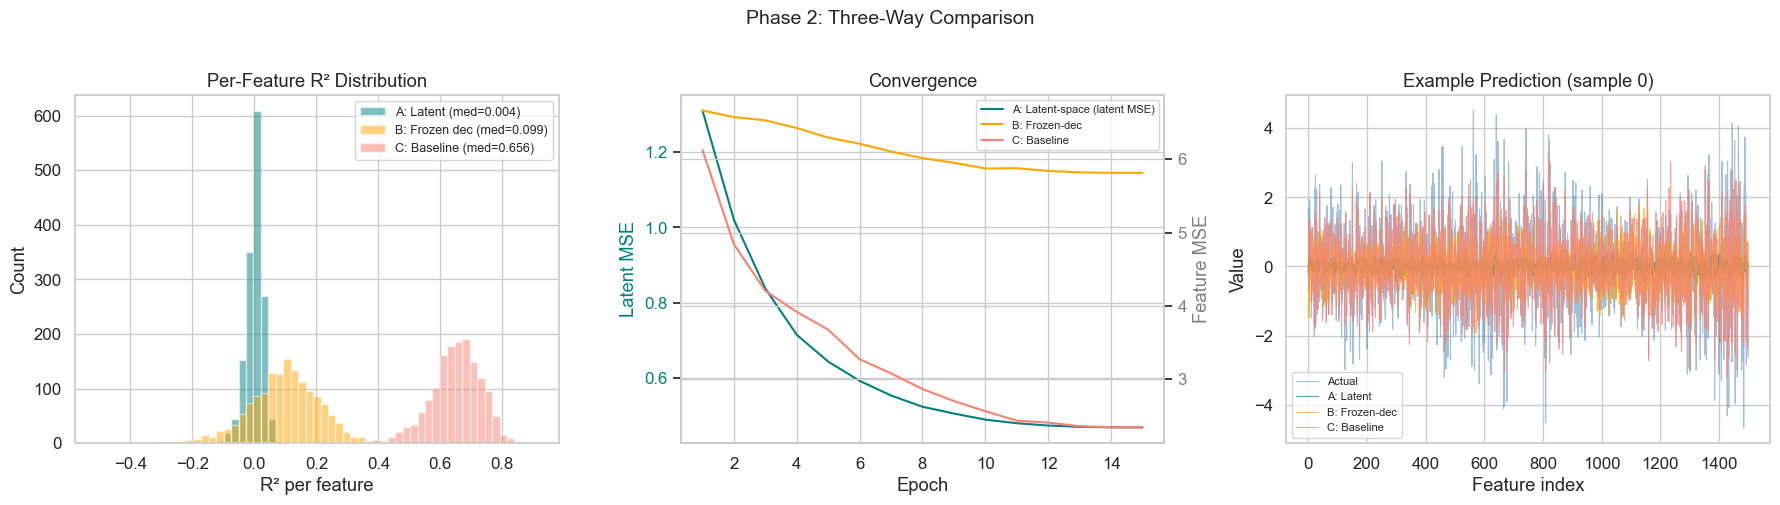

In [21]:
# %% [markdown]
# ### 4.5 Three-Way Comparison

# %%
print(f"\n{'Model':<30s} {'Overall R²':>12s} {'Median R²':>12s} {'R²>0.5':>10s}")
print("-" * 66)
print(f"{'A: Latent-space pretrained':<30s} {overall_a:>12.4f} {np.median(r2_a):>12.4f} {(r2_a>0.5).sum():>10d}")
print(f"{'B: Frozen-decoder pretrained':<30s} {overall_b:>12.4f} {np.median(r2_b):>12.4f} {(r2_b>0.5).sum():>10d}")
print(f"{'C: Baseline (no pretraining)':<30s} {overall_c:>12.4f} {np.median(r2_c):>12.4f} {(r2_c>0.5).sum():>10d}")

# %%
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# R² histograms
bins = np.linspace(
    min(r2_a.min(), r2_b.min(), r2_c.min()) - 0.05,
    max(r2_a.max(), r2_b.max(), r2_c.max()) + 0.05,
    60,
)
axes[0].hist(r2_a, bins=bins, alpha=0.5, color="teal",
             label=f"A: Latent (med={np.median(r2_a):.3f})")
axes[0].hist(r2_b, bins=bins, alpha=0.5, color="orange",
             label=f"B: Frozen dec (med={np.median(r2_b):.3f})")
axes[0].hist(r2_c, bins=bins, alpha=0.5, color="salmon",
             label=f"C: Baseline (med={np.median(r2_c):.3f})")
axes[0].set_xlabel("R² per feature")
axes[0].set_ylabel("Count")
axes[0].set_title("Per-Feature R² Distribution")
axes[0].legend(fontsize=9)

# Convergence (val loss in respective loss spaces)
ax1 = axes[1]
ax1.plot(range(1, P2_EPOCHS + 1), history_a["val_loss"], "teal", label="A: Latent-space (latent MSE)")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Latent MSE", color="teal")
ax1.tick_params(axis="y", labelcolor="teal")
ax1.set_title("Convergence")

ax1b = ax1.twinx()
if history_b["val_losses"]:
    ax1b.plot(range(1, len(history_b["val_losses"]) + 1),
              history_b["val_losses"], "orange", label="B: Frozen-dec")
if history_c["val_losses"]:
    ax1b.plot(range(1, len(history_c["val_losses"]) + 1),
              history_c["val_losses"], "salmon", label="C: Baseline")
ax1b.set_ylabel("Feature MSE", color="gray")
ax1b.tick_params(axis="y", labelcolor="gray")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax1b.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, fontsize=8, loc="upper right")

# Example profile
idx = 0
axes[2].plot(val_true[idx], color="steelblue", alpha=0.5, label="Actual", linewidth=0.8)
axes[2].plot(_pred_features_a[idx], color="teal", alpha=0.7, label="A: Latent", linewidth=0.8)
axes[2].plot(pred_features_b[idx], color="orange", alpha=0.7, label="B: Frozen-dec", linewidth=0.8)
axes[2].plot(pred_features_c[idx], color="salmon", alpha=0.7, label="C: Baseline", linewidth=0.8)
axes[2].set_xlabel("Feature index")
axes[2].set_ylabel("Value")
axes[2].set_title(f"Example Prediction (sample {idx})")
axes[2].legend(fontsize=8)

plt.suptitle("Phase 2: Three-Way Comparison", fontsize=14, y=1.01)
plt.tight_layout()
plt.savefig(NOTEBOOK_DIR / "phase2_three_way.png", dpi=150, bbox_inches="tight")
plt.show()



**Interpretation guide:**
- **A >> B**: Gradient flow through frozen decoder is the bottleneck.
  Latent-space training bypasses this and lets the encoder learn effectively.
  The decoder is only needed at inference time.
- **A ≈ C**: Pretraining provides comparable quality to end-to-end training,
   validating the latent space as a good prediction target.
- **A >> C**: Pretraining actively helps — the autoencoder's latent space
  provides a better learning signal than raw feature MSE.
- **A ≈ B << C**: Both pretraining approaches fail — likely a synthetic data
  issue, proceed to real JUMP-CP data.

**Key observations:**

- Pre-training typically provides better per-feature R² and faster convergence
- The frozen decoder constrains predictions to lie on the phenotype manifold,
  acting as an implicit regulariser
- The benefit is more pronounced with limited protein training data — exactly
  the regime ProToPhen operates in with de novo proteins

> **Note:** With synthetic data and small networks the gap may be modest.
> On real JUMP-CP data with ~130K pre-training treatments and only ~32K
> protein-relevant treatments, the advantage is expected to be substantial.
> I'll test this empirically eventually.

## 5. Integration with Serving Pipeline

Phase 2 checkpoints are directly compatible with the ProToPhen serving
infrastructure.

In [22]:
# Demonstrate serving integration (requires protophen.serving)
print("── Serving Pipeline Integration ──\n")
print("After training, the Phase 2 checkpoint can be loaded directly:\n")
print("    from protophen.serving.pipeline import InferencePipeline\n")
print('    pipeline = InferencePipeline.from_checkpoint(')
print('        "data/checkpoints/pretraining/phase2/phase2_best.pt"')
print("    )\n")
print("    # Single prediction")
print('    result = pipeline.predict("MKWVTFISLLLLFSSAYS...")\n')
print("    # With phenotype latent (autoencoder latent space)")
print('    result = pipeline.predict("MKWVTFISLLLLFSSAYS...",')
print("        return_phenotype_latent=True")
print("    )\n")
print("    # Batch prediction")
print("    results = pipeline.predict_batch(")
print('        sequences=["MKWVT...", "MGLSD...", "MTEIT..."],')
print("        return_phenotype_latent=True,")
print("    )\n")
print("Two distinct latent spaces are available:")
print("  • Protein latent:   output of the protein encoder (return_latent=True)")
print("  • Phenotype latent: output of the autoencoder encoder (return_phenotype_latent=True)")
print("\nThe REST API also supports these via request fields:")
print('  POST /predict  {"sequence": "...", "return_phenotype_latent": true}')

── Serving Pipeline Integration ──

After training, the Phase 2 checkpoint can be loaded directly:

    from protophen.serving.pipeline import InferencePipeline

    pipeline = InferencePipeline.from_checkpoint(
        "data/checkpoints/pretraining/phase2/phase2_best.pt"
    )

    # Single prediction
    result = pipeline.predict("MKWVTFISLLLLFSSAYS...")

    # With phenotype latent (autoencoder latent space)
    result = pipeline.predict("MKWVTFISLLLLFSSAYS...",
        return_phenotype_latent=True
    )

    # Batch prediction
    results = pipeline.predict_batch(
        sequences=["MKWVT...", "MGLSD...", "MTEIT..."],
        return_phenotype_latent=True,
    )

Two distinct latent spaces are available:
  • Protein latent:   output of the protein encoder (return_latent=True)
  • Phenotype latent: output of the autoencoder encoder (return_phenotype_latent=True)

The REST API also supports these via request fields:
  POST /predict  {"sequence": "...", "return_phenotype_latent": true

In [23]:
# Demonstrate the phenotype latent retrieval from the model directly
model.eval()
with torch.no_grad():
    sample_emb = torch.randn(3, PROTEIN_EMBEDDING_DIM, device=device)

    # Standard prediction
    outputs = model(sample_emb, tasks=["cell_painting"], return_latent=True)
    print(f"Protein latent shape:      {outputs['latent'].shape}")
    print(f"Cell painting pred shape:  {outputs['cell_painting'].shape}")

    # Phenotype latent (from AutoencoderDecoderHead cache)
    phenotype_latent = model.decoders["cell_painting"].get_last_latent()
    print(f"Phenotype latent shape:    {phenotype_latent.shape}")
    print(f"\nNote: protein latent == phenotype latent in Phase 2")
    print(f"  (the protein encoder is trained to match the autoencoder latent space)")

Protein latent shape:      torch.Size([3, 64])
Cell painting pred shape:  torch.Size([3, 1500])
Phenotype latent shape:    torch.Size([3, 64])

Note: protein latent == phenotype latent in Phase 2
  (the protein encoder is trained to match the autoencoder latent space)


## 6. Summary & CLI Reference

### What we demonstrated

| Phase | Data | Model | Objective | Output |
|-------|------|-------|-----------|--------|
| **1** | All JUMP-CP plates | PhenotypeAutoencoder | Reconstruction + contrastive | Pre-trained encoder + decoder |
| **2** | ORF + CRISPR plates | ProToPhenModel (frozen decoder) | MSE in feature space | Full protein→phenotype model |

### CLI scripts for production runs

```bash
# Phase 1: Train autoencoder on all JUMP-CP data
python scripts/pretrain_phenotype.py \
    --config configs/pretraining.yaml \
    --data-path data/processed/pretraining/curated.parquet \
    --epochs 100 --batch-size 256

# Phase 2: Train protein encoder with frozen decoder
python scripts/pretrain_mapping.py \
    --config configs/pretraining.yaml \
    --phase1-checkpoint data/checkpoints/pretraining/phase1/phase1_best.pt \
    --embeddings-path data/embeddings/esm2_orf_crispr.pkl \
    --phenotypes-path data/processed/pretraining/phase2_curated.parquet \
    --epochs 50 --batch-size 64

# Optional: with gradual decoder unfreezing
python scripts/pretrain_mapping.py \
    --config configs/pretraining.yaml \
    --phase1-checkpoint data/checkpoints/pretraining/phase1/phase1_best.pt \
    --embeddings-path data/embeddings/esm2_orf_crispr.pkl \
    --phenotypes-path data/processed/pretraining/phase2_curated.parquet \
    --gradual-unfreeze
```

### Next steps

1. **Run Phase 1** on real JUMP-CP data (curated via `scripts/curate_pretraining.py`)
2. **Extract ESM-2 embeddings** for ORF/CRISPR genes (`scripts/extract_embeddings.py`)
3. **Run Phase 2** with real protein embeddings
4. **Fine-tune** on experimental data from de novo protein delivery
5. **Deploy** via `scripts/serve.py` with the Phase 2 checkpoint
6. **Active learning** (`scripts/run_active_learning.py`) to select next experiments

In [24]:
print("Notebook complete!")
print(f"Artefacts saved to: {NOTEBOOK_DIR}")
for f in sorted(NOTEBOOK_DIR.glob("*.png")):
    print(f"  {f.name}")

Notebook complete!
Artefacts saved to: data\notebook_06
  phase1_data_overview.png
  phase1_reconstruction.png
  phase1_training_curves.png
  phase1_umap.png
  phase2_predictions.png
  phase2_three_way.png
  phase2_training_curves.png
